In [1]:
!gdown --id 1qk0iAVLh9IonluBu6ixCUT_uIn3hHUCu                                                               # download zipfile

Downloading...
From: https://drive.google.com/uc?id=1qk0iAVLh9IonluBu6ixCUT_uIn3hHUCu
To: /content/foto retak.zip
100% 532M/532M [00:07<00:00, 72.4MB/s]


In [2]:
!mkdir data                                                                                                 # buat folder
!mkdir model                                                                                                # buat folder
!unzip "/content/foto retak.zip" -d "data"                                                                  # unzip

Archive:  /content/foto retak.zip
   creating: data/retak buaya/
  inflating: data/retak buaya/IMG_20210602_104642.jpg  
  inflating: data/retak buaya/IMG_20210602_104812.jpg  
  inflating: data/retak buaya/IMG_20210602_104931.jpg  
  inflating: data/retak buaya/IMG_20210602_105434.jpg  
  inflating: data/retak buaya/IMG_20210602_105450-01.jpeg  
  inflating: data/retak buaya/IMG_20210602_105450.jpg  
 extracting: data/retak buaya/IMG_20210602_105501-01.jpeg  
  inflating: data/retak buaya/IMG_20210602_105501.jpg  
 extracting: data/retak buaya/IMG_20210602_105504-01.jpeg  
  inflating: data/retak buaya/IMG_20210602_105504.jpg  
  inflating: data/retak buaya/IMG_20210602_105507-01.jpeg  
  inflating: data/retak buaya/IMG_20210602_105507.jpg  
  inflating: data/retak buaya/IMG_20210602_105511.jpg  
  inflating: data/retak buaya/IMG_20210602_105533.jpg  
  inflating: data/retak buaya/IMG_20210602_105547.jpg  
  inflating: data/retak buaya/IMG_20210602_105640.jpg  
  inflating: data/retak

In [3]:
# import libraries
import os
import tqdm
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import pywt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as imshow

# resolusi gambar
shape = (512,512)

In [4]:
image_path = []                                                                                             # membuat list kosong untuk lokasi image
label = []                                                                                                  # membuat list kosong untuk label sesuai dengan folder
for folder in os.listdir("data"):                                                                           # loop setiap folder yang ada dalam folder data
  folder_path = os.path.join("data",folder)                                                                 # buat variable berisi path dari folder tiap kategori gambar
  for img in os.listdir(folder_path):                                                                       # loop tiap folder kategori gambar
    image_path.append(os.path.join(folder_path,img))                                                        # tambahkan path gambar ke list image_path
    label.append(folder)                                                                                    # tambahkan nama folder ke dalam list label
pd.DataFrame({                                                                                              # menampilkan path dan label dalam bentuk tabel
    "image":image_path,
    "label":label
})

,image,label
0,data/retak garis/IMG_20210609_112346.jpg,retak garis
1,data/retak garis/IMG_20210609_113039.jpg,retak garis
2,data/retak garis/IMG_20210609_112137.jpg,retak garis
3,data/retak garis/IMG_20210609_112301.jpg,retak garis
4,data/retak garis/IMG_20210609_111640.jpg,retak garis
...,...,...
214,data/tidak retak/IMG_20211011_142720.jpg,tidak retak
215,data/tidak retak/tidak retak 5.jpg,tidak retak
216,data/tidak retak/IMG_20211011_145015.jpg,tidak retak
217,data/tidak retak/IMG_20211011_142419.jpg,tidak retak


In [5]:
image = []                                                                                                  # membuat list kosong untuk image array
cats = []                                                                                                   # membuat list kosong untuk category label
for img,lbl in tqdm(zip(image_path,label)):                                                                 # loop setiap image path
  arr = cv2.imread(img)                                                                                     # membaca image
  arr = cv2.resize(arr,shape)                                                                               # resize image
  arr = cv2.cvtColor(arr, cv2.COLOR_BGR2LAB)                                                                # convert BGR ke CIE Lab
  l, a, b = cv2.split(arr)                                                                                  # split image channels
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))                                                # membuat fungsi adaptive histogram equalization, untuk memperbaiki contrast
  cl = clahe.apply(l)                                                                                       # apply fungsi adaptve histogram equalization terhadap channel l
  arr = cv2.merge((cl,a,b))                                                                                 # merge kembali ketiga channle gambar
  arr = cv2.cvtColor(arr, cv2.COLOR_LAB2BGR)                                                                # convert CIE Lab ke BGR
  arr = cv2.cvtColor(arr,cv2.COLOR_BGR2GRAY)                                                                # convert ke grayscale
  coeffs2 = pywt.dwt2(arr, 'bior1.3')                                                                       # transformasi wavelet
  LL, (LH, HL, HH) = coeffs2                                                                                # membuat variable untuk setiap approximation
  image.append(LL.tolist())                                                                                 # add hasil transformasi wavelet ke list image
  image.append(LH.tolist())                                                                                 # add hasil transformasi wavelet ke list image
  image.append(HL.tolist())                                                                                 # add hasil transformasi wavelet ke list image
  image.append(HH.tolist())                                                                                 # add hasil transformasi wavelet ke list image
  cats.append(lbl)                                                                                          # add label ke list cats
  cats.append(lbl)                                                                                          # add label ke list cats
  cats.append(lbl)                                                                                          # add label ke list cats
  cats.append(lbl)                                                                                          # add label ke list cats

219it [00:38,  5.72it/s]


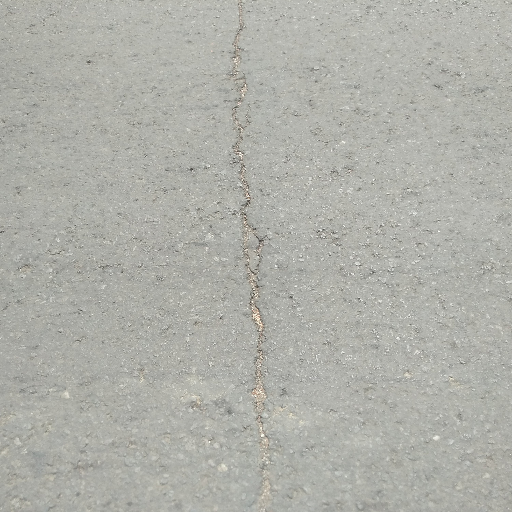

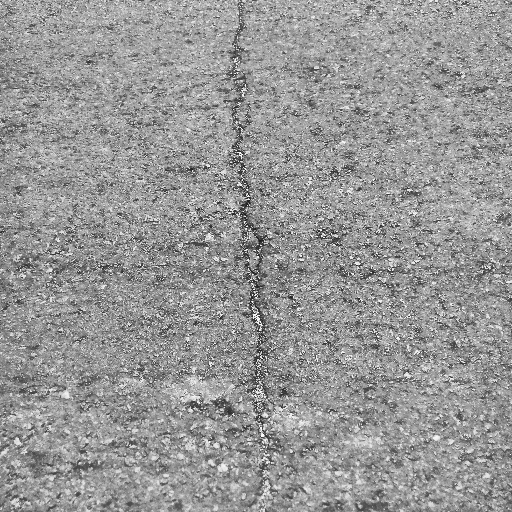

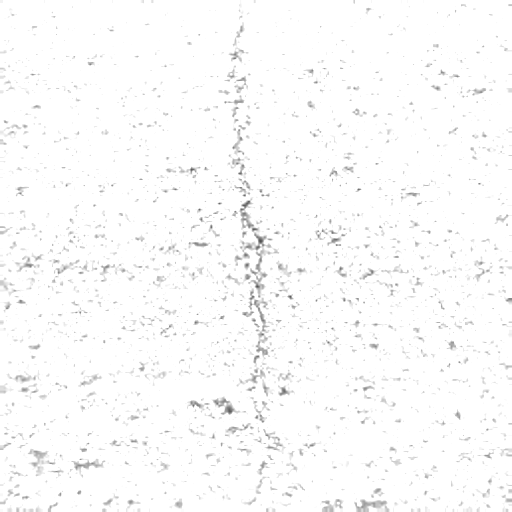

In [6]:
# testing dan menampilkan sample hasil transformasi
test = cv2.imread(image_path[3])
test = cv2.resize(test,shape)
imshow(np.array(test))
test = cv2.cvtColor(test, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(test)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
cl = clahe.apply(l)
test = cv2.merge((cl,a,b))
test = cv2.cvtColor(test, cv2.COLOR_LAB2BGR)
test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
coeffs2 = pywt.dwt2(test, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
imshow(np.array(test))
WV = cv2.resize(LL,shape)
imshow(np.array(WV))

In [7]:
le = LabelEncoder()                                                                                                               # membuat fungsi label encoding
X = np.array(image)/255                                                                                                           # membuat variable X berisi image array yang telah di-transformed dan di normalisasi
y = le.fit_transform(cats)                                                                                                        # mentransformasi kategori menjadi numerical
le.classes_                                                                                                                       # menampilka class

array(['retak buaya', 'retak garis', 'tidak retak'], dtype='<U11')

In [8]:
input_shape = (X.shape[1],X.shape[2])                                                                                        # membuat variable input_shape sebagai input shape model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y), test_size=0.2, shuffle=True, random_state=42)   # membagi data training dan validasi 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True, random_state=42)             # membuat data validasi dari data training 80:20
X_train = X_train.reshape(-1, input_shape[0], input_shape[1], 1)                                                             # reshape X_train
X_val = X_val.reshape(-1, input_shape[0], input_shape[1], 1)                                                                 # resahpe X_val
X_test = X_test.reshape(-1, input_shape[0], input_shape[1], 1)                                                               # reshape X_test

In [10]:
model = Sequential()                                                                                                         # inisiasi model dengan sequential
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(input_shape[0], input_shape[1],1)))                    # add cnn 2D layer dengan activation layer relu dan mendefinisikan input shape
model.add(MaxPool2D())                                                                                                       # add layer maxpool 2D

model.add(Conv2D(32, 3, padding="same", activation="relu"))                                                                  # add cnn 2D layer dengan activation layer relu
model.add(MaxPool2D())                                                                                                       # add layer maxpool 2D

model.add(Conv2D(64, 3, padding="same", activation="relu"))                                                                  # add cnn 2D layer dengan activation layer relu
model.add(MaxPool2D())                                                                                                       # add layer maxpool 2D
model.add(Dropout(0.4))                                                                                                      # add layer droput

model.add(Flatten())                                                                                                         # add fungsi flatten
model.add(Dense(128,activation="relu"))                                                                                      # add dense layer dengan relu activation
model.add(Dense(3, activation="softmax"))                                                                                    # add dense layer dengan softmax activation, 3 nodes output sesuai target label

model.summary()                                                                                                              # menampilkan model summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 258, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 129, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 129, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0

In [11]:
model.compile(optimizer = "sgd" , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])                    # compile model dengan optimiser schocastic gradient descent, loss function Sparse Categorical Cross Entrpy dan metrics yang diukur accuracy

In [12]:
history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_val, y_val))                                                  # fit model dengan backpropagation secara default (default keras sudah menggunakan backpropagation)

Epoch 1/500
18/18 [==============================] - 33s 169ms/step - loss: 1.1034 - accuracy: 0.3268 - val_loss: 1.0914 - val_accuracy: 0.3571
Epoch 2/500
18/18 [==============================] - 2s 102ms/step - loss: 1.0987 - accuracy: 0.3464 - val_loss: 1.0889 - val_accuracy: 0.3286
Epoch 3/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0890 - accuracy: 0.3696 - val_loss: 1.0955 - val_accuracy: 0.4786
Epoch 4/500
18/18 [==============================] - 2s 102ms/step - loss: 1.0850 - accuracy: 0.4393 - val_loss: 1.1002 - val_accuracy: 0.3714
Epoch 5/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0795 - accuracy: 0.4679 - val_loss: 1.0680 - val_accuracy: 0.3929
Epoch 6/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0699 - accuracy: 0.4786 - val_loss: 1.0660 - val_accuracy: 0.3929
Epoch 7/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0492 - accuracy: 0.4982 - val_loss: 1.0507 - val_accuracy: 0.428

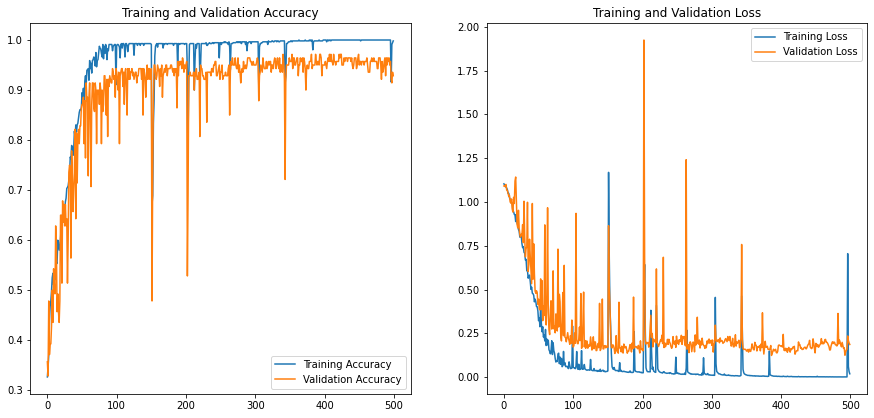

In [13]:
# membuat variabel tiap kategori matrics hasil training, baik data training ataupun validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# membuat range epoch untuk X axis
epochs_range = range(500)

plt.figure(figsize=(15, 15))                                                                  # setup ukuran gambar
plt.subplot(2, 2, 1)                                                                          # subplot posisi pertama
plt.plot(epochs_range, acc, label='Training Accuracy')                                        # line chart training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                  # line chart validation accuracy
plt.legend(loc='lower right')                                                                 # lokasi legend
plt.title('Training and Validation Accuracy')                                                 # judul chart

plt.subplot(2, 2, 2)                                                                          # sublplot posisi pertama
plt.plot(epochs_range, loss, label='Training Loss')                                           # linechart training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')                                     # linechart validation loss
plt.legend(loc='upper right')                                                                 # posisi legend
plt.title('Training and Validation Loss')                                                     # judul chart
plt.show()                                                                                    # menampilkan chart

In [14]:
loss,accuracy = model.evaluate(X_test, y_test, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.9431818127632141
Model loss     :  0.20857834815979004


In [15]:
predictions = model.predict(X_test)                                                                         # membuat prediksi terhadap data test
predictions = np.argmax(predictions, axis=-1)                                                               # konversi hasil prediksi sesuai dengan bentuk array y_test
print(classification_report(y_test, predictions, target_names = le.classes_))                               # menampilkan classification report

              precision    recall  f1-score   support

 retak buaya       0.98      0.87      0.92        68
 retak garis       0.95      0.98      0.97        57
 tidak retak       0.89      1.00      0.94        51

    accuracy                           0.94       176
   macro avg       0.94      0.95      0.94       176
weighted avg       0.95      0.94      0.94       176



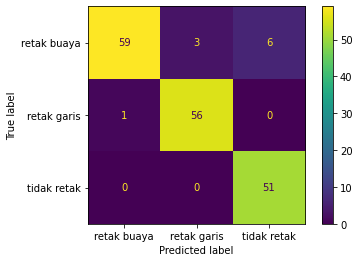

In [16]:
cm = confusion_matrix(y_test, predictions)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.show()                                                                                                  # menampilkan hasil plot

In [17]:
model.save("/content/model/")

INFO:tensorflow:Assets written to: /content/model/assets


In [18]:
!zip -r model.zip "/content/model/"

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 89%)
  adding: content/model/keras_metadata.pb (deflated 92%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/variables/variables.index (deflated 56%)
